In [1]:
# NOTE: do not run this notebook in weird orders.
# due to variable persistence that will break the graphs


# imports
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import numpy as np
import re, glob
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# useful constants, update once groupthink works
tasks = ["interpolation", "extrapolation"]
models = {"pondernet" : "Pondernet",
          "groupthink" : "Groupthink",
          "aRGT" : "aRGT",
          "pondernet_mnist" : "Pondernet MNIST"}
elems = {"interpolation": 16, "extrapolation": 24}

In [3]:
def get_paths(path):
    """Fetches all relevant paths"""
    files = []
    for f in glob.glob(path):
        files.append(f)
    return files

def parse_tensorboard(path, scalars):
    """returns a dictionary of pandas dataframes for each requested scalar"""
    ea = event_accumulator.EventAccumulator(
        path,
        size_guidance={event_accumulator.SCALARS: 0},
    )
    _absorb_print = ea.Reload()
    # make sure the scalars are in the event accumulator tags
    if not all(
        s in ea.Tags()["scalars"] for s in scalars
    ):
        return None
    assert all(
        s in ea.Tags()["scalars"] for s in scalars
    ), f"some scalars were not found in the event accumulator, {scalars}"
    return {k: pd.DataFrame(ea.Scalars(k)) for k in scalars}

def get_df(paths, scalars):
    """Gets all dfs of all logs files according to the desired scalars and combines them.
    Only use this if you have single values per scalar per log file, not for time series."""
    df_list = {s:[] for s in scalars}
    for f in paths:
        dict_df = parse_tensorboard(f, scalars)
        if not dict_df:
            # print(f"Not all requested metrics found in {f}")
            continue
        for key, val in dict_df.items():
            val["file"] = f
            val.rename(columns={'value': key}, inplace=True)
            val = val.set_index(val["file"])
            df_list[key].append(val[["step", key]])
    dict_result = {s : pd.concat(df_list[s]) for s in scalars}
    df = pd.concat(list(dict_result.values()), axis = 1)
    df.reset_index(drop=True, inplace=True)
    return df

def get_timeseries_df(paths, scalars):
    """Gets all dfs of all log files and merges them according to similar step."""
    df_list = {s:[] for s in scalars}
    for i, f in enumerate(paths):
        dict_df = parse_tensorboard(f, scalars)
        if not dict_df:
            # print(f"Not all requested metrics found in {f}")
            continue
        for key, val in dict_df.items():
            val.rename(columns={'value': key+f"-v{i}"}, inplace=True)
            val.set_index(val["step"], inplace=True)
            df_list[key].append(val.drop(["wall_time"], axis=1))
    dict_result = {s : (pd.concat(df_list[s], axis=1)).drop(["step"], axis=1) for s in scalars}
    for s in scalars:
        dict_result[s]["Average"] = dict_result[s].mean(axis = 1)
    return dict_result

def get_metrics(type_data, scalars, models):
    """Gets metrics"""
    dfs = {}
    for m in models.keys():
        dfs[m] = {}
        for t in tasks:
            if m == "pondernet_mnist":
                num_elems = 28
            else:
                num_elems = elems[t]
            dir_path = f"../models/{m}_{t}_{num_elems}/*/*events*"
            if type_data == "scalars":
                files = get_paths(dir_path)
                df = get_df(files, scalars)
                dfs[m][t] = df.drop(["step"], axis=1)
            elif type_data == "timeseries":
                files = get_paths(dir_path)
                dfs[m][t] = get_timeseries_df(files, scalars) 
    if type_data == "scalars":
        to_graph = {t:{s:{m:dfs[m][t][[s]] for m in models} for s in scalars} for t in tasks}
    elif type_data == "timeseries":
        to_graph = {t:{s:{m:dfs[m][t][s] for m in models} for s in scalars} for t in tasks}
    return to_graph

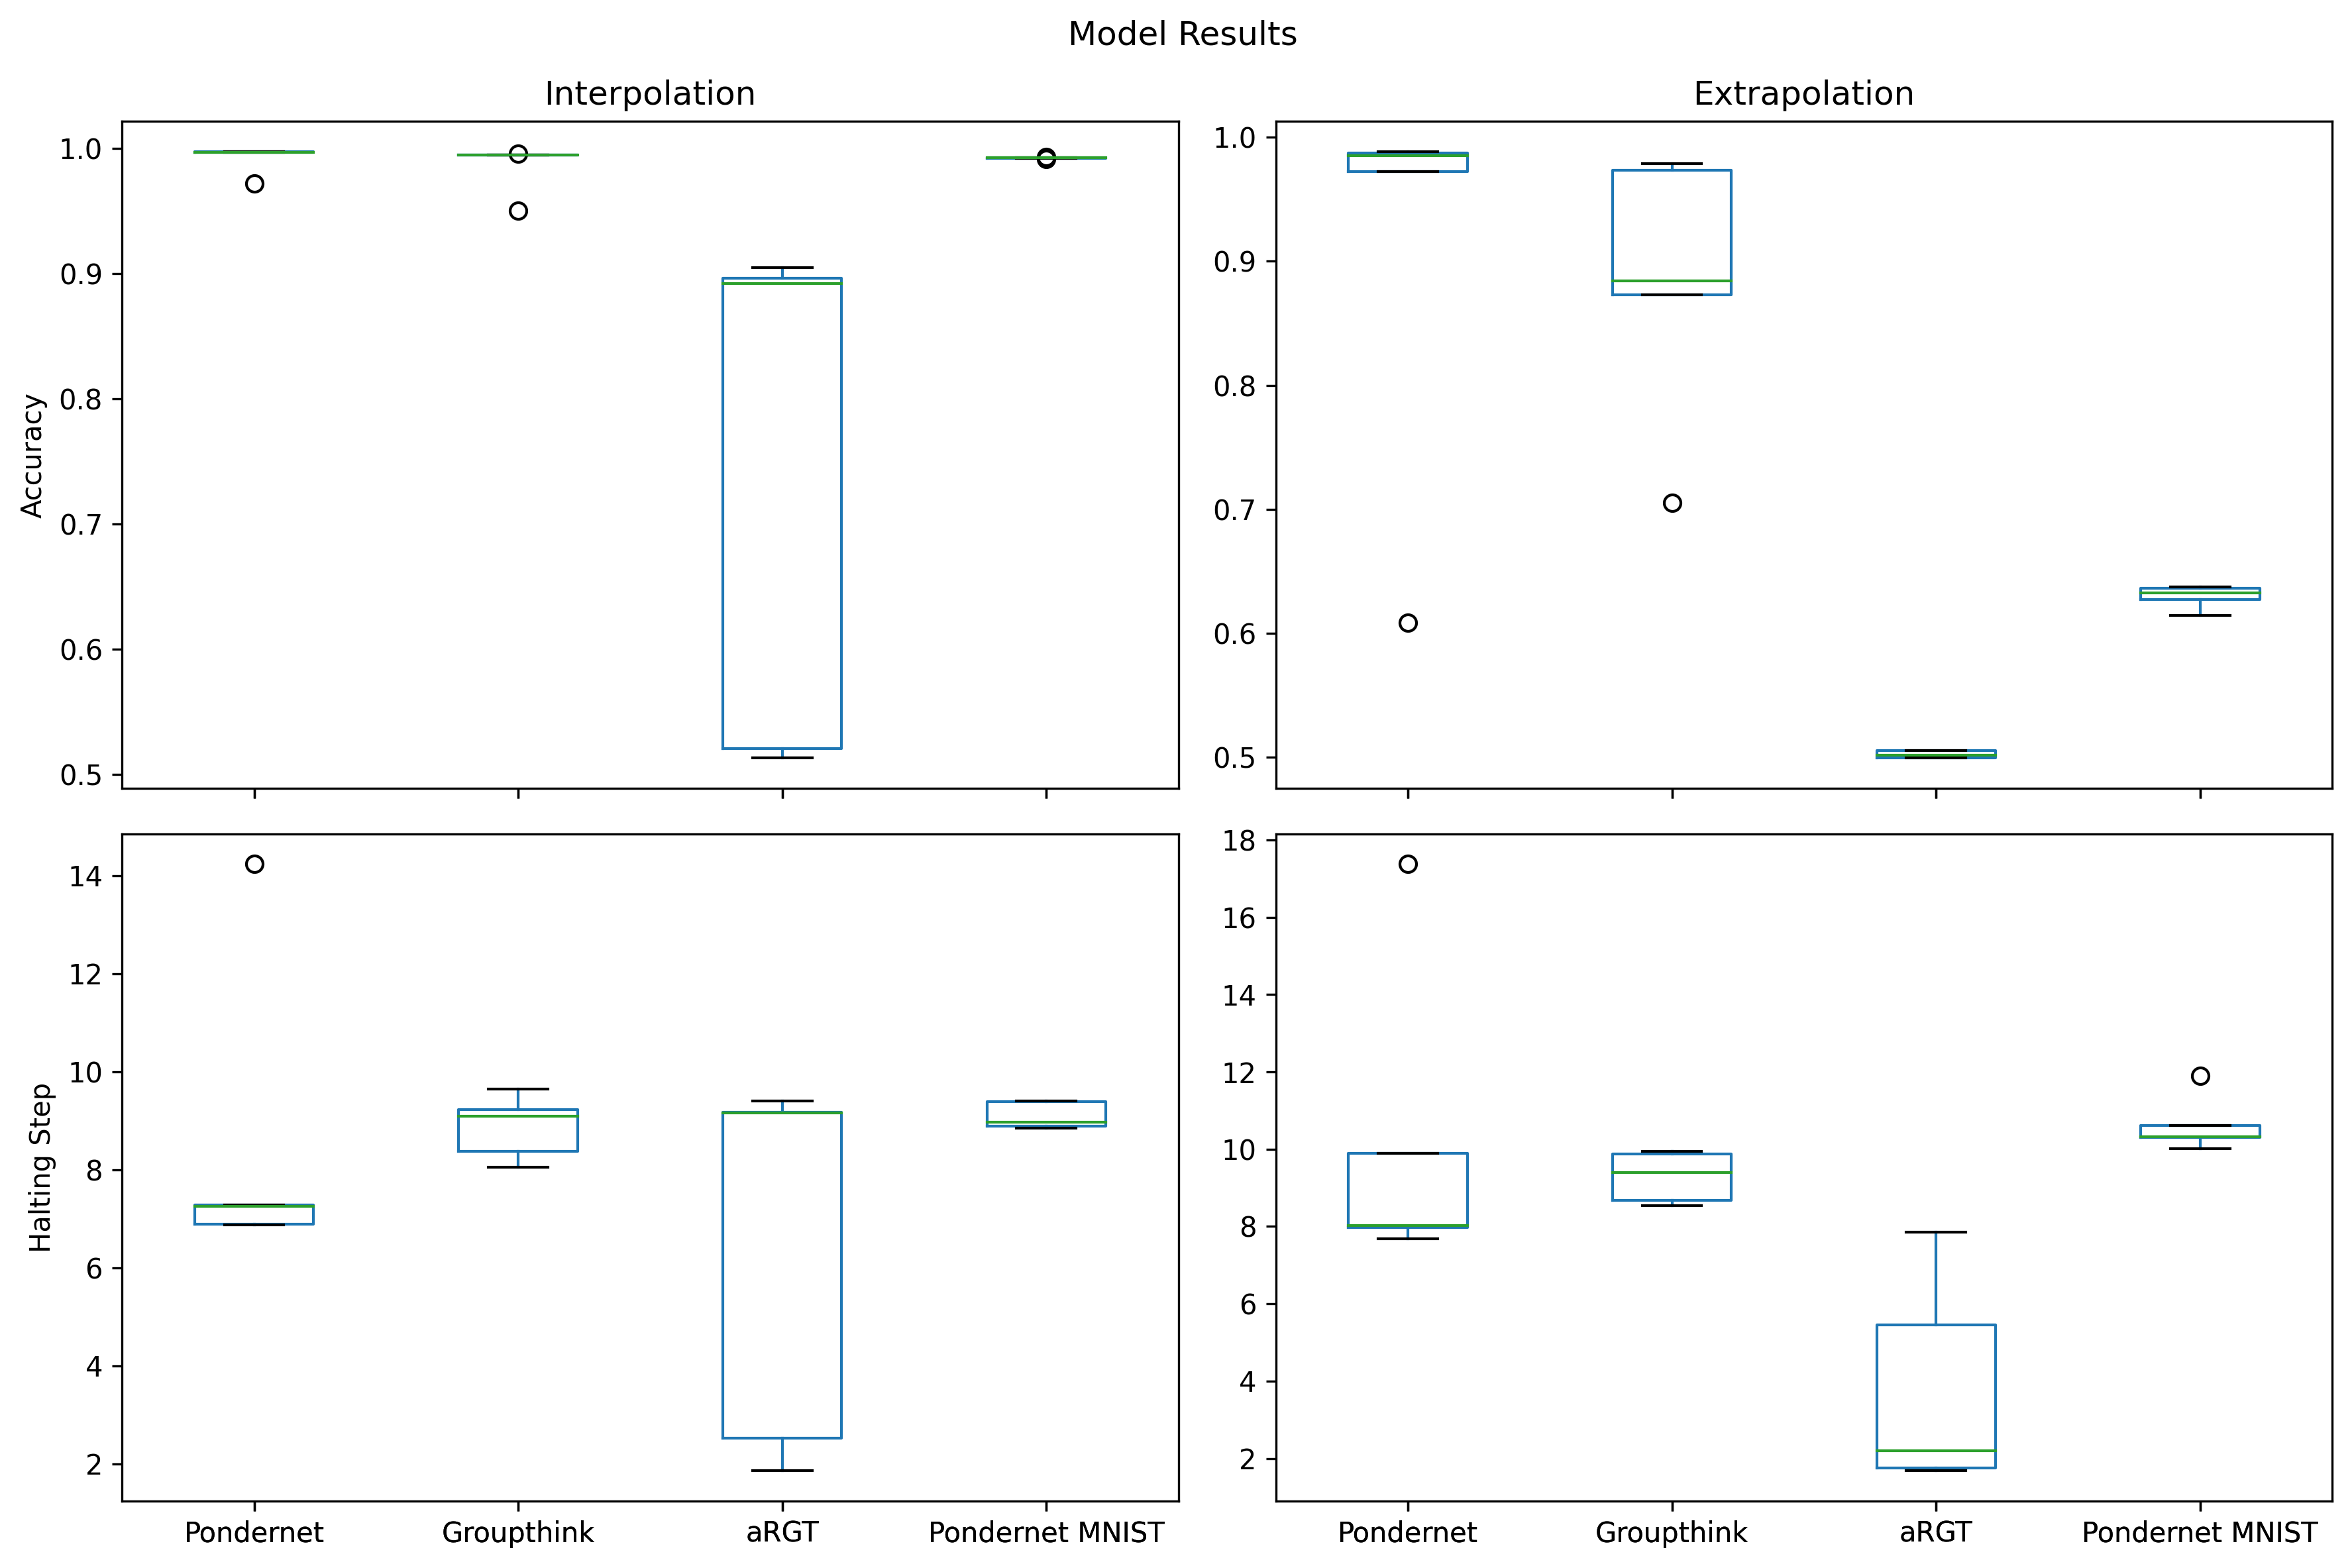

In [4]:
# plotting scalars at test for comparison across models
scalars = ['test/accuracy_halted_step', 'test/halting_step']
to_graph = get_metrics("scalars", scalars, models)
f, axs = plt.subplots(2, 2, dpi=300, figsize=(12, 8), sharex="col")
for i, t in enumerate(tasks):
    for j, s in enumerate(scalars):
        for m in models.keys():
            to_graph[t][s][m].rename(columns={s: models[m]}, inplace=True)
        boxplt = pd.concat([to_graph[t][s][m] for m in models], axis=1)
        boxplt.boxplot(ax=axs[j,i], grid = False)
        if i % 2 == 0:
            if j % 2 == 0:
                axs[j,i].set_ylabel("Accuracy")
            else:
                axs[j,i].set_ylabel("Halting Step")
    axs[0,i].set_title(t.title())
plt.suptitle('Model Results')
plt.tight_layout()
plt.show()

In [5]:
# make a table of above results for report
to_table = to_graph
header = pd.MultiIndex.from_product([[t.title() for t in tasks], ["Average", "Standard Err"]], )
df = pd.DataFrame(columns = header, index=models.values())
for s in scalars:
    print(f"Scalar {s}:")
    for t in tasks:
        for m in models.keys():
            data = to_table[t][s][m]
            df[(t.title(), "Average")][models[m]] = data.mean().values[0]
            df[(t.title(), "Standard Err")][models[m]] = data.std().values[0] / np.sqrt(data.size)
    display(df)
            
    

Scalar test/accuracy_halted_step:


Interpolation              Extrapolation             
                      Average Standard Err       Average Standard Err
Pondernet            0.991898     0.004998      0.908273     0.075007
Groupthink           0.985984     0.008959      0.882786     0.049458
aRGT                  0.74548     0.093262      0.502277      0.00134
Pondernet MNIST       0.99214     0.000242       0.62962     0.004167

Scalar test/halting_step:


Interpolation              Extrapolation             
                      Average Standard Err       Average Standard Err
Pondernet            8.508477     1.435078     10.191391     1.838414
Groupthink           8.880875     0.290562      9.285258     0.295536
aRGT                 6.425062     1.733592      3.787955     1.231788
Pondernet MNIST       9.10056     0.123737      10.63502     0.330613

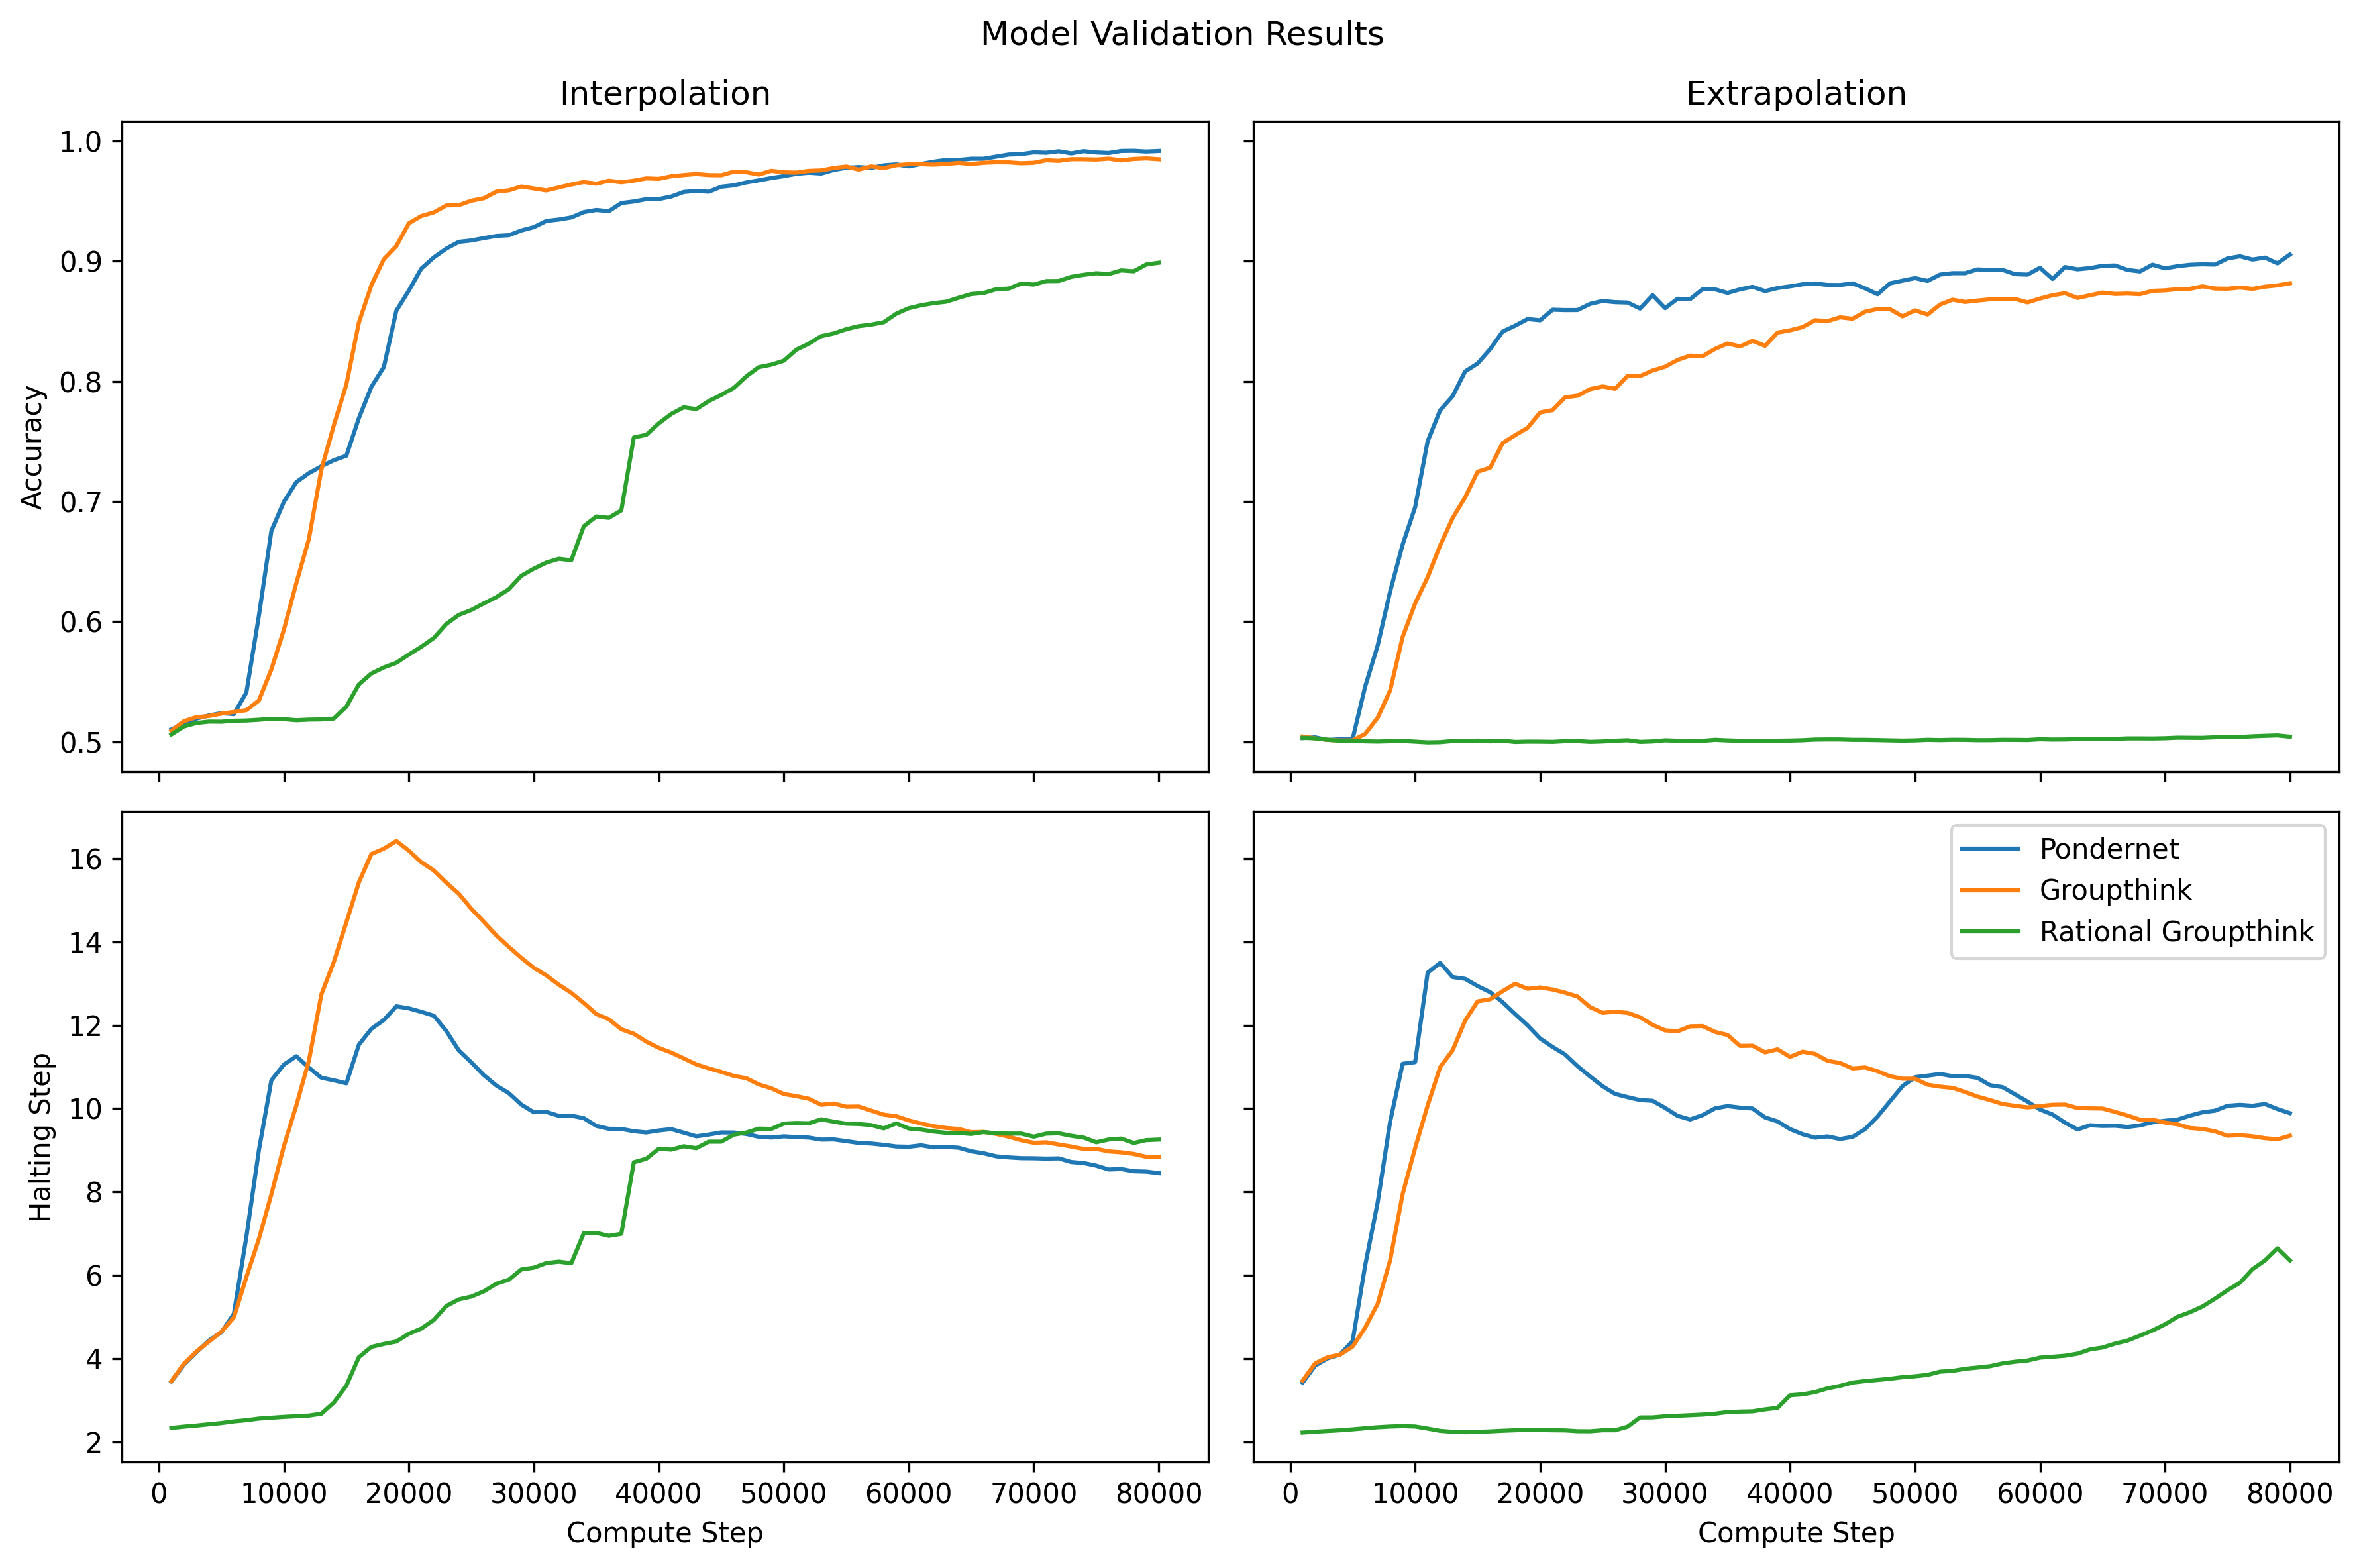

In [6]:
# plotting time series of training for comparison across models
scalars = ['val/accuracy_halted_step', 'val/halting_step']
models = {"pondernet" : "Pondernet",
          "groupthink" : "Groupthink",
          "aRGT" : "Rational Groupthink"}
to_graph = get_metrics("timeseries", scalars, models)
f, axs = plt.subplots(len(tasks), len(scalars), dpi=300, figsize=(12, 8), sharey="row", sharex="col")
for i, t in enumerate(tasks):
    for j, s in enumerate(scalars):
        for m in models.keys():
            data = to_graph[t][s][m]
            data.rename(columns={"Average": models[m]}, inplace=True)
            data[models[m]].plot(ax=axs[j,i], grid = False, style=["-"])
            if i % 2 == 0:
                if j % 2 == 0:
                    axs[j,i].set_ylabel("Accuracy")
                else:
                    axs[j,i].set_ylabel("Halting Step")
    axs[0,i].set_title(t.title())
    axs[1,i].set_xlabel("Compute Step")
axs[1,1].legend()
plt.suptitle('Model Validation Results')
plt.tight_layout()
plt.show()

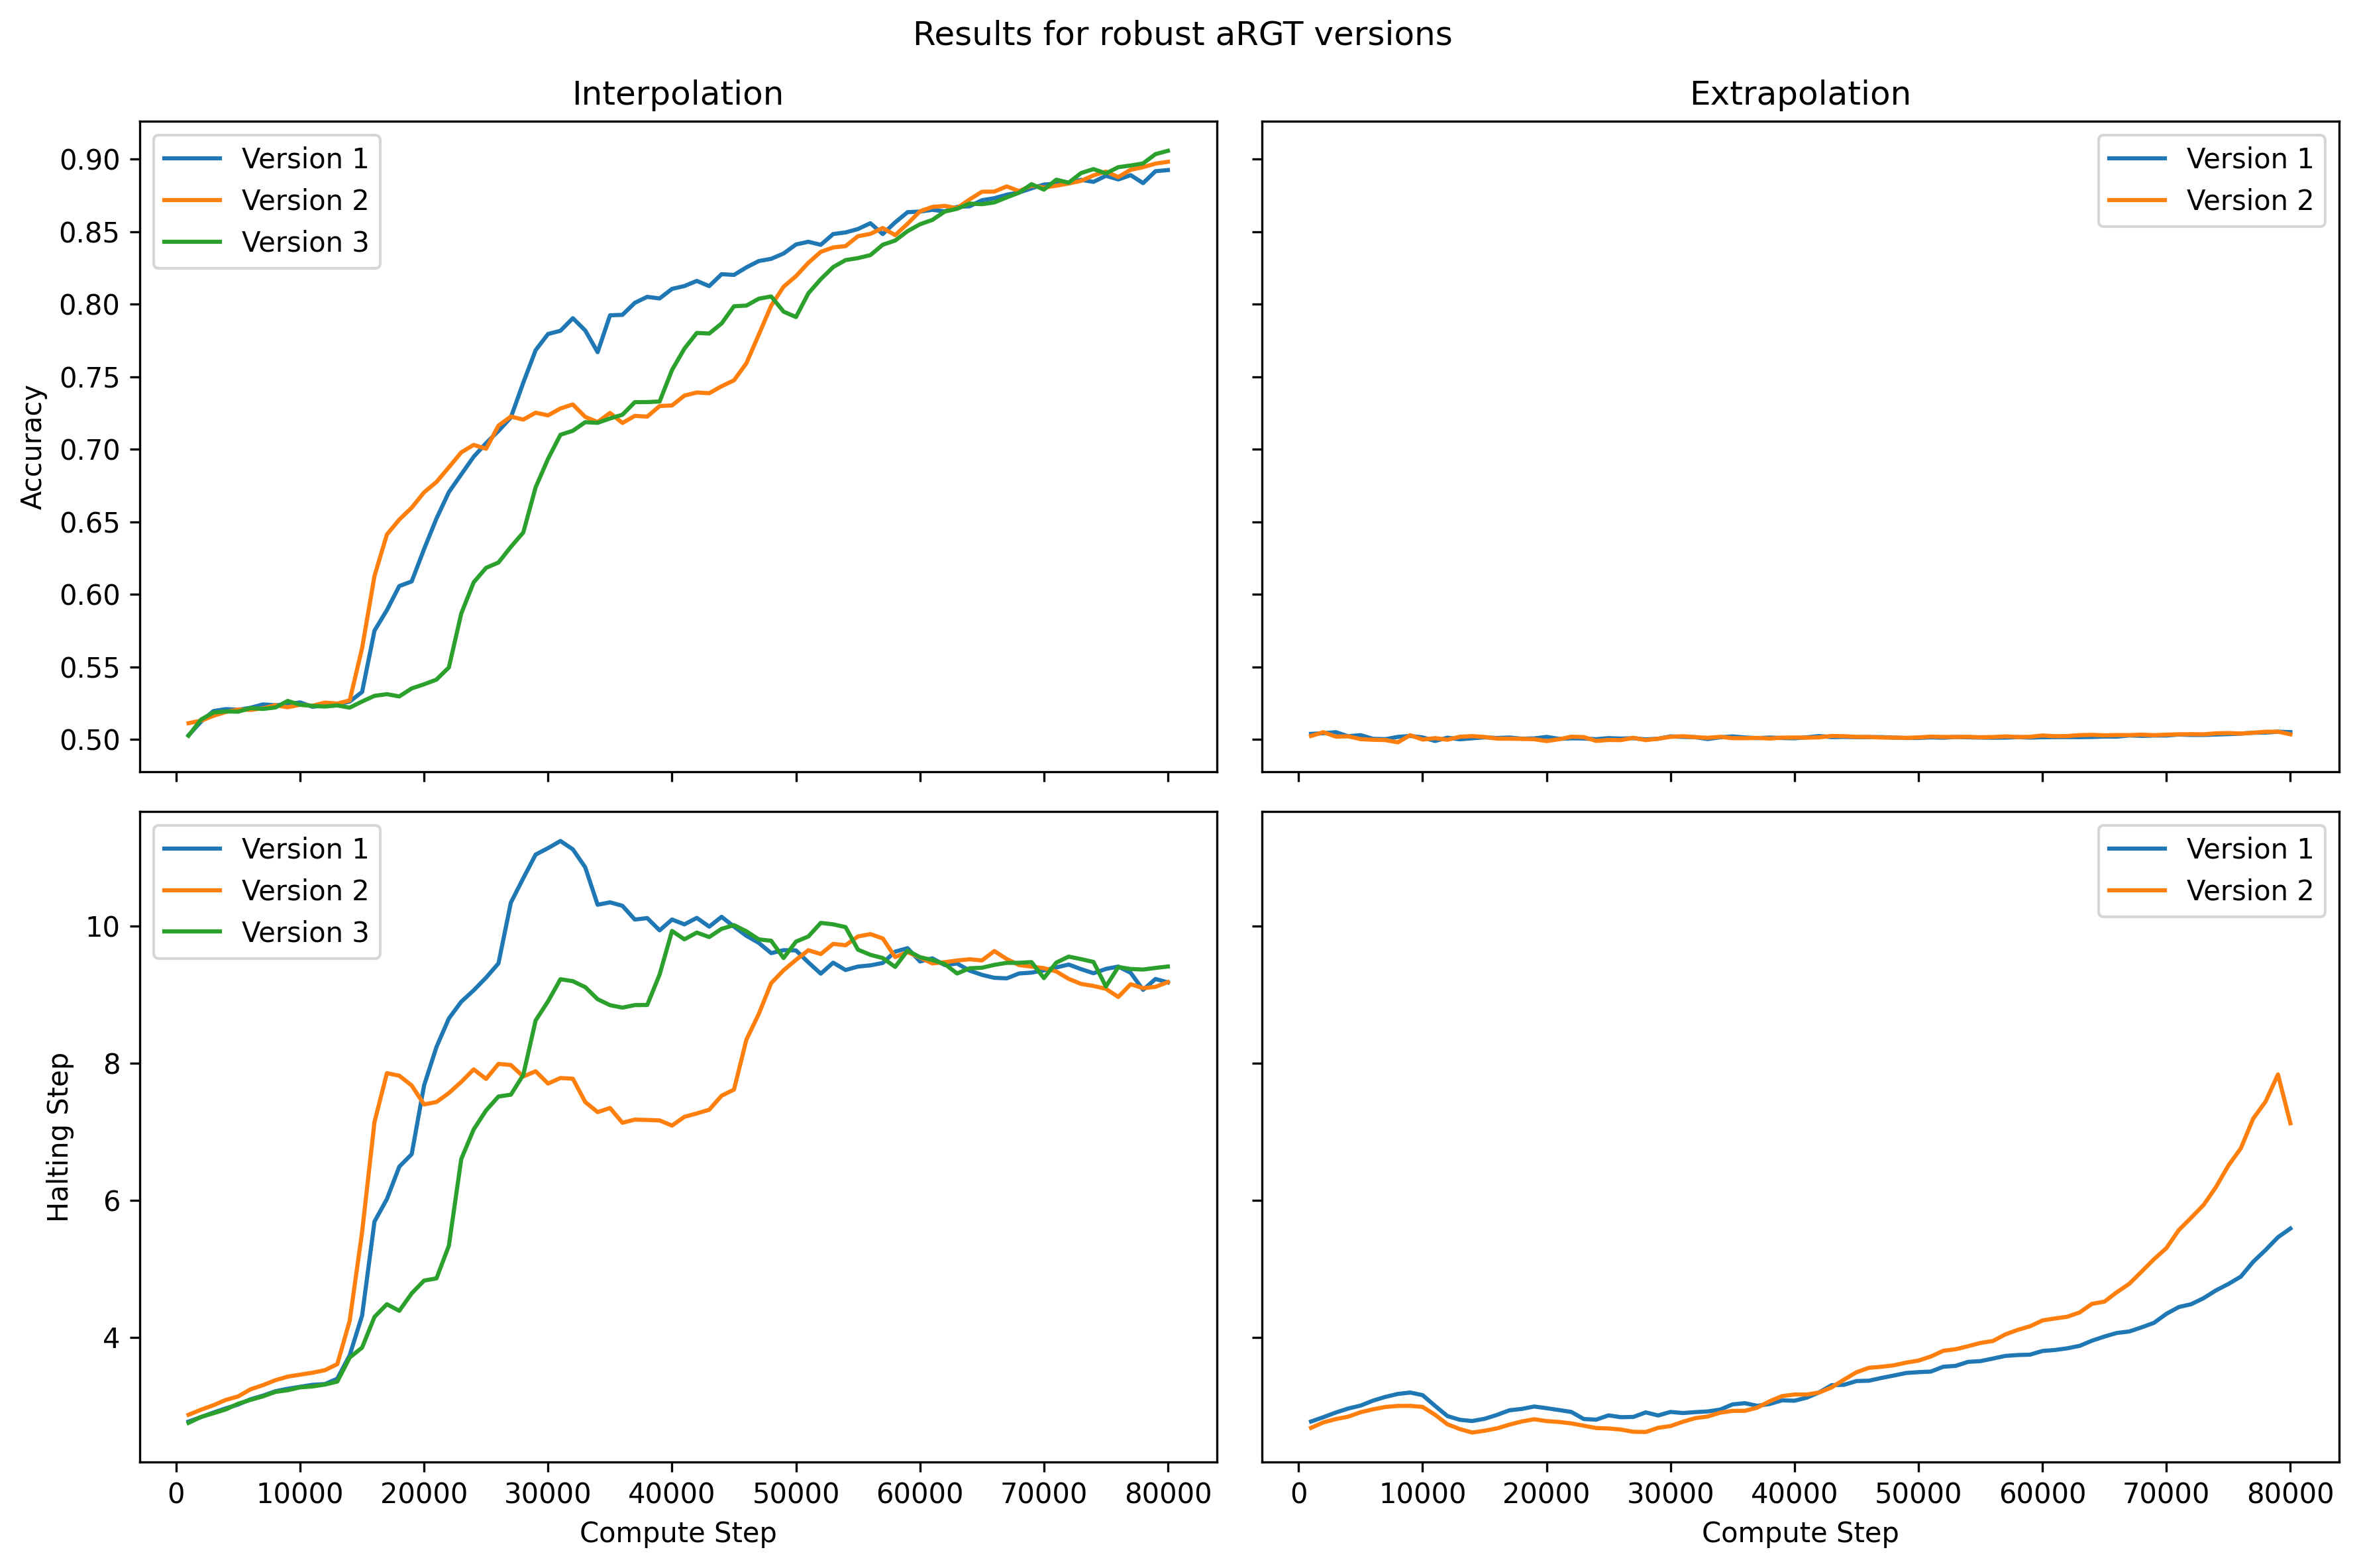

In [7]:
# plot accuracy curves and halting steps for not crashed aRGTs
models = {"aRGT" : "Rational Groupthink"}
f, axs = plt.subplots(len(tasks), len(scalars), dpi=300, figsize=(12, 8), sharey="row", sharex="col")
for i, t in enumerate(tasks):
    for j, s in enumerate(scalars):
        for m in models.keys():
            if m == "aRGT":
                data = to_graph[t][s][m]
                data = data[data.columns[~data.isnull().any()]].drop([models[m]], axis=1)
                data.rename(columns={name:f"Version {i+1}" for i, name in enumerate(data.columns)}, inplace=True)
                data.plot(ax=axs[j,i], grid = False, style=["-"])
                if i % 2 == 0:
                    if j % 2 == 0:
                        axs[j,i].set_ylabel("Accuracy")
                    else:
                        axs[j,i].set_ylabel("Halting Step")
    axs[0,i].set_title(t.title())
    axs[1,i].set_xlabel("Compute Step")
axs[1,1].legend()
plt.suptitle('Results for robust aRGT versions')
plt.tight_layout()
plt.show()


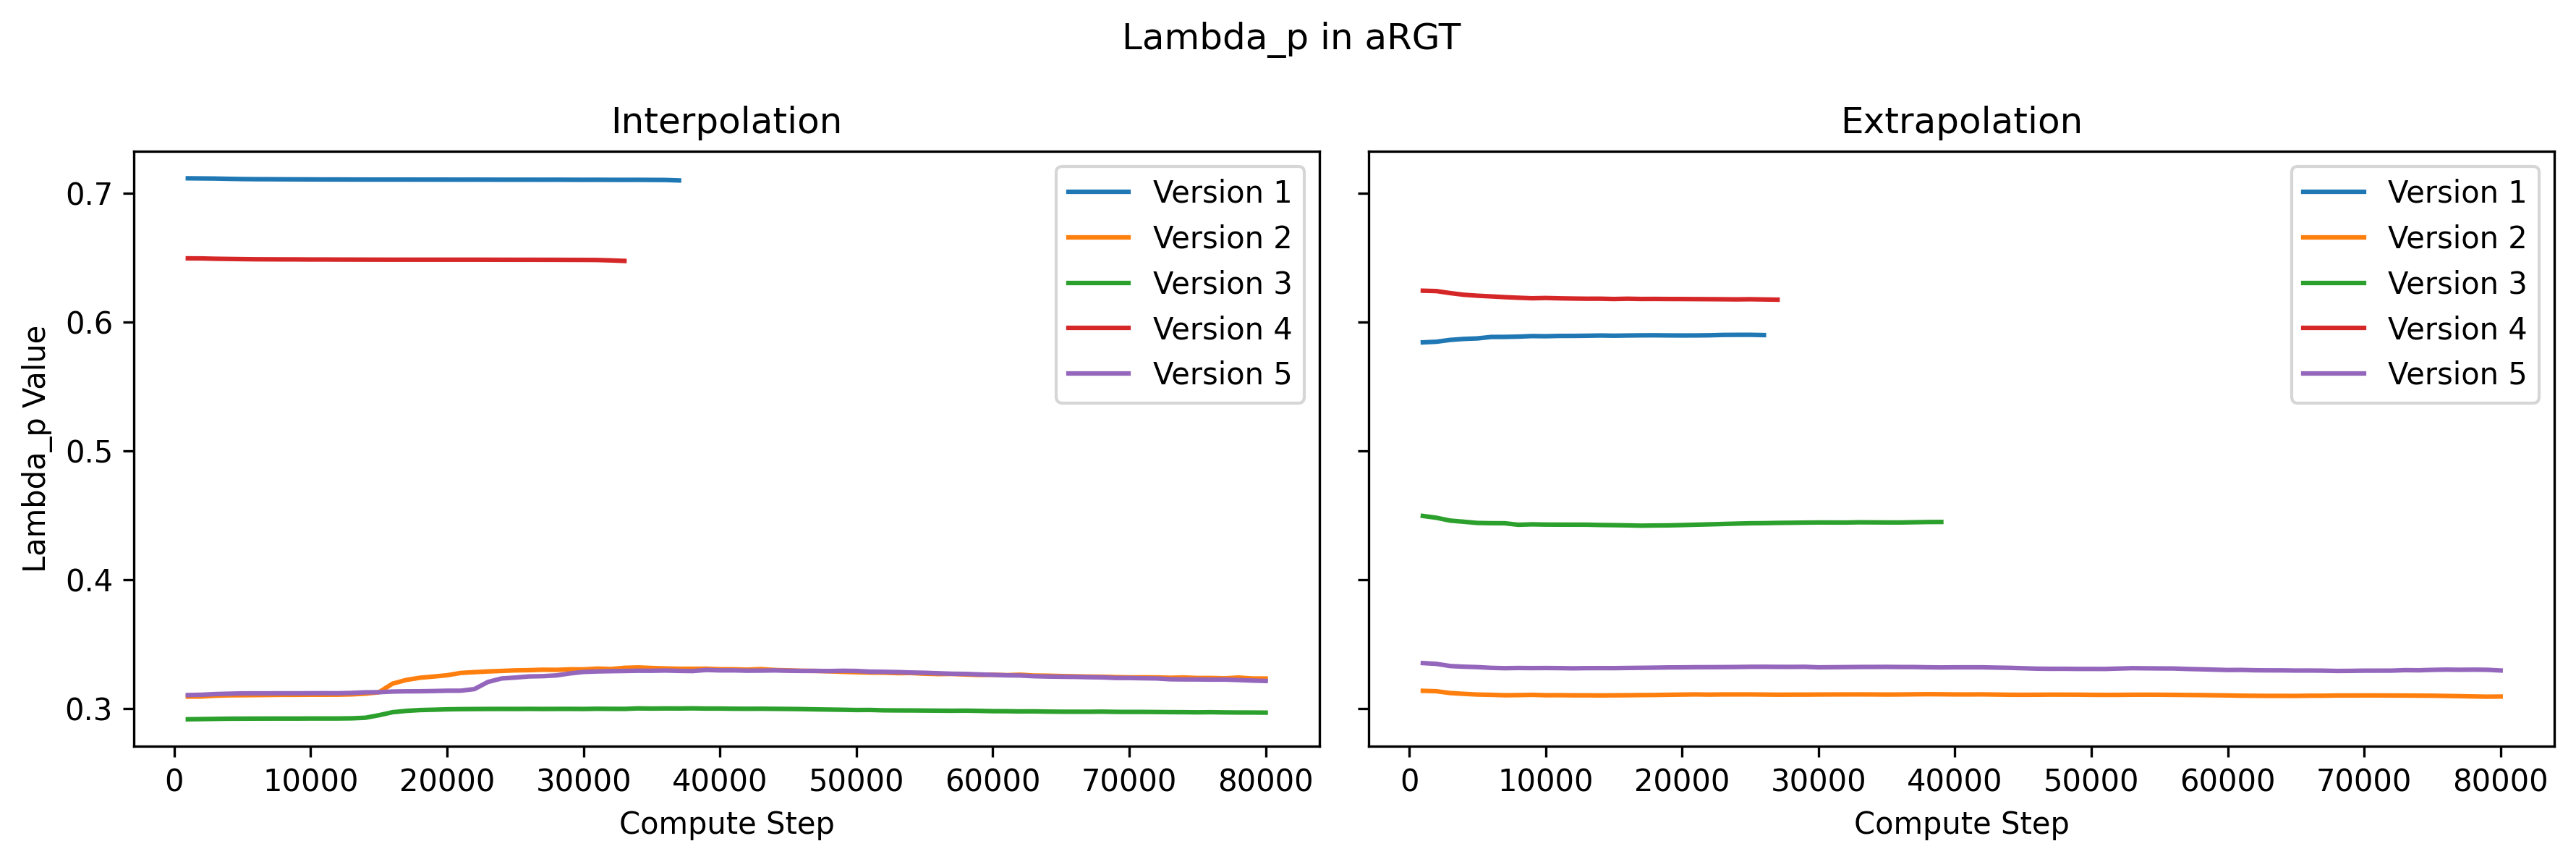

In [8]:
# plot lambda_p for aRGT
scalars = ['val/lambda_p']
models = {"aRGT" : "Rational Groupthink"}
to_graph = get_metrics("timeseries", scalars, models)
f, axs = plt.subplots(1, len(tasks), dpi=300, figsize=(12, 4), sharey="row")
for i, t in enumerate(tasks):
    for s in scalars:
        for m in models.keys():
            data = to_graph[t][s][m].drop(["Average"], axis=1)
            data.rename(columns={name:f"Version {i+1}" for i, name in enumerate(data.columns)}, inplace=True)
            data.plot(ax=axs[i], grid = False, style=["-"], label=f"")
    axs[0].set_ylabel("Lambda_p Value")
    axs[i].set_title(t.title())
    axs[i].set_xlabel("Compute Step")
axs[1].legend()
plt.suptitle('Lambda_p in aRGT')
plt.tight_layout()
plt.show()